In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import os

# plot omega

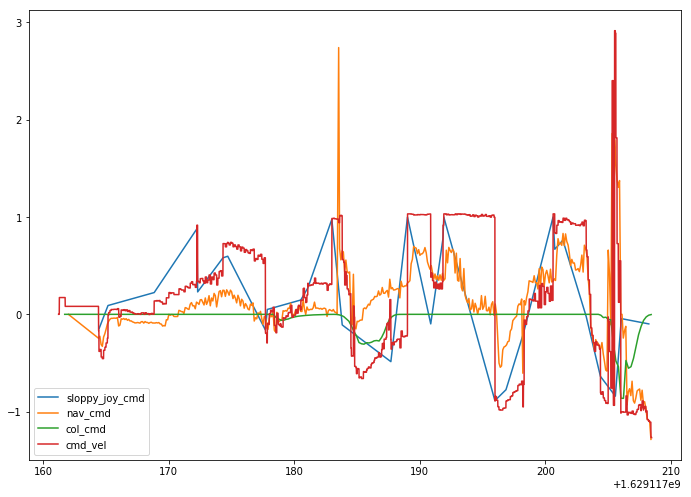

In [94]:
participent_nr = 6# choose participent

'''
calculates the difference betweeen two topics even if they are not synchronous.

It always uses the time resolution of the reference_data
'''
def calculate_difference(data,reference_data,control_axis):
    differences = []
    for index, row in reference_data.iterrows():
        reference_time      = row['time']
        smaller_indexes     = np.array((data['time'] <=reference_time).tolist())
        matching_data_index = np.argmin(smaller_indexes)
        difference          = data[control_axis][matching_data_index] -row[control_axis]
        differences.append(difference)
    return differences


bag_name = "main_circuit"
def plot_similarity(experiment,control_axis):
    twist_topic_list = ['sloppy_joy_cmd', 'nav_cmd','col_cmd','cmd_vel']
    final_twist_df   = pd.read_csv("../experimental_data/participent_" + str(participent_nr) + "/" + experiment + "/twist_cmd_vel.csv")

    plt.figure(figsize = (11.69,8.27))
    for topic_name in twist_topic_list:
        twist_df   = pd.read_csv("../experimental_data/participent_" + str(participent_nr) + "/" + experiment + "/twist_" + topic_name + ".csv")
        difference = calculate_difference(twist_df,final_twist_df,control_axis)
        #plt.plot(final_twist_df['time'], difference, label=topic_name)
        plt.plot(twist_df['time'], twist_df[control_axis], label=topic_name)

    plt.legend(loc="lower left")
    plt.show()

plot_similarity("main_circuit",'omega')

# plot odom

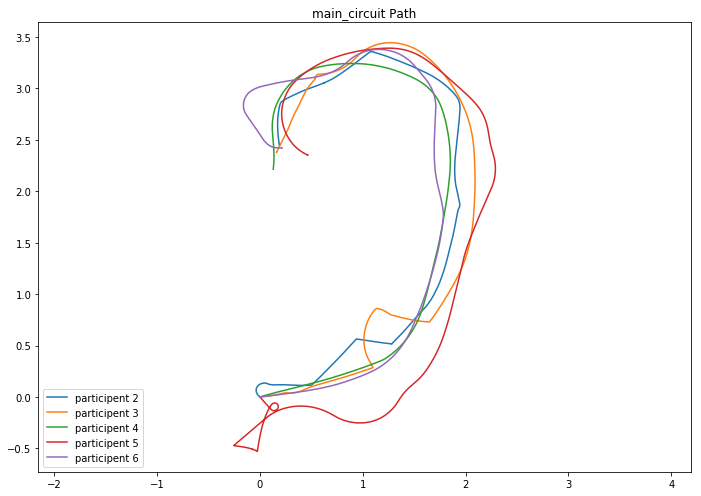

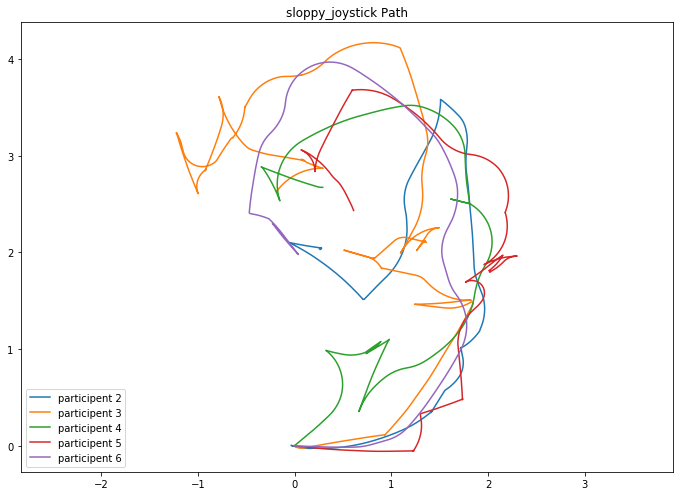

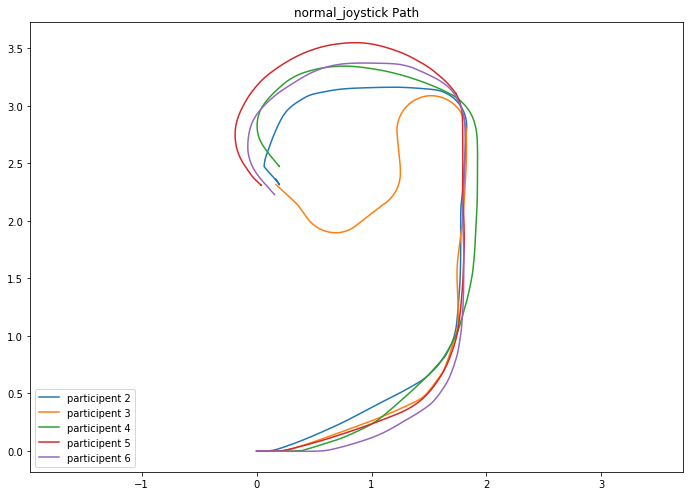

In [95]:
'''
rotate a odometry dataframe so that its initial orientation is yaw= 0
'''
def rotate_odom(odom_df):
    new_df = deepcopy(odom_df)
    initial_yaw = odom_df['yaw'][0]
    rot = np.array([[np.cos(-initial_yaw), -np.sin(-initial_yaw)], [np.sin(-initial_yaw), np.cos(-initial_yaw)]])
    for index, row in new_df.iterrows():
        pos         = np.array([row['x'],row['y']])
        rotated_pos = np.dot(rot,pos)
        
        new_df['x'][index]  = rotated_pos[0]
        new_df['y'][index]  = rotated_pos[1]
        new_df['yaw'][index]= new_df['yaw'][index]-initial_yaw
    return new_df



def plot_odom(experiment):
    participent_numbers = [2,3,4,5,6] 
    plt.figure(figsize=(11.69,8.27))
    for participent_nr in participent_numbers:
        orig_odom_df = pd.read_csv("../experimental_data/participent_" + str(participent_nr) + "/" + experiment + "/odom.csv")
        #rotate dataframe to account for initial yaw orientation in odometry:
        odom_df = rotate_odom(orig_odom_df)
        plt.plot(odom_df['x'], odom_df['y'], label="participent "+str(participent_nr))
    plt.legend(loc="lower left")
    plt.title(experiment+" Path")
    plt.axis('equal')
    plt.show()

    

    
plot_odom("main_circuit")
plot_odom("sloppy_joystick")
plot_odom("normal_joystick")

In [ ]:
# Time to target
# inf if not reached because collision

In [ ]:
# create a HTML file for easy access (without jupyter)
os.system('jupyter nbconvert --to html visualization.ipynb') 
os.system('mv visualization.html ./html') # move to html folder